## ICPAC Analysis Ethiopia
Exploration of the usage of ICPAC forecasted data for determining expected drought in Admin1 regions as part of the Anticapatory Action Framework

What we have:
- most current forecast of ICPAC in raster format (.nc and .tiff)

Other data
- IPC-level per livelihood in vector format
- OCHA admin boundaries in vector format
- Population per 1km from WorldPop in raster format
- Population per admin (up to admin3 level) in vector format (though outdated)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats

In [36]:
INPUT_SHP_FEWSNET = "Experiments/Data/ET_LHZ_2018/ET_LHZ_2018.shp" #"../Data/FewsNetRaw/east-africa202008/EA_202008_ML1.shp"#

In [37]:
#this tif was extracted in QGIS from the Ens_Prec_1monLead_OND_ProbEnsRegrCPT-avg.nc file since the OND2020Forecast.tiff somehow has mismatching coordinates (while the CRS is the same)
#this file was shared to us by ICPAC but cannot be shared publicly!!
FORECAST_TIFF = "Experiments/Data/ICPAC_sep2020_below.tif"
POPULATION_TIFF= "Data/WorldPopUNAdj/eth_ppp_2020_1km_Aggregated_UNadj.tif"
INPUT_SHP_ADM1 = "Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"

#### Calculating the probability value per Admin1 region
**Note: we should discuss if this is the best way to go!**  
It was chosen to look at the maximum value of the raster cells present in an Admin1 region. Another option would be to take the mean but this quickly underestimates the severity of the below rainfall, especially for regions where cells are projected to not have below rainfall. 

Which raster cells are inside an admin1 region can be calculated in two ways: either all cells which have their centre inside the boundaries. Or all cells which touch the polygon boundaries (or are completely inside). Given the fact that the size of the raster cells of the ICPAC forecast are rather large, it was chosen to use the second option. However, the disadvantage of this approach it that there is a high sensitivity for small parts of a cell falling inside a polygon. 

In [13]:
df_adm = gpd.read_file(INPUT_SHP_ADM1)
#extract statistics for each polygon. all_touched=True includes all cells that touch a polygon, with all_touched=False only those with the center inside the polygon are counted.
df_adm["max_icpac"]=pd.DataFrame(
        zonal_stats(vectors=df_adm, raster=FORECAST_TIFF, all_touched=True, band=1, nodata=-9999))["max"]
df_adm=df_adm[["ADM1_EN","max_icpac","geometry"]]

/Users/tinkavalentijn/opt/anaconda3/envs/rast/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


(32.24197800000007, 48.738062000000085, 2.834729654650078, 15.417417252350031)

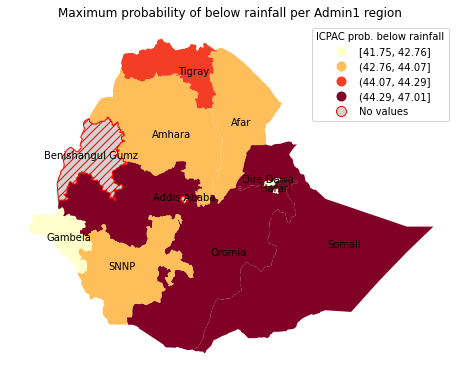

In [14]:
#plot the maximum value per admin1
fig, axis = plt.subplots(figsize=(8,16))
df_adm.plot(column="max_icpac",scheme='Quantiles',k=4,ax=axis,legend=True,legend_kwds={"title":"ICPAC prob. below rainfall"},missing_kwds={"color": "lightgrey", "edgecolor": "red",
   "hatch": "///",
    "label": "No values"},cmap="YlOrRd")
df_adm['coords'] = df_adm['geometry'].apply(lambda x: x.representative_point().coords[:])
df_adm['coords'] = [coords[0] for coords in df_adm['coords']]
for idx, row in df_adm.iterrows():
    plt.annotate(s=row['ADM1_EN'], xy=row['coords'],
                 horizontalalignment='center')
plt.title("Maximum probability of below rainfall per Admin1 region")
axis.axis("off")

### Calculating the probability value per livelihood
**Note: have to revisit this methodology, should first intersect raster of pop with raster of ICPAC**

In [15]:
#calculate population and icpac probability per livelihood-admin1 combination
df_liv=gpd.read_file(INPUT_SHP_FEWSNET)
#get (the parts of) each livelihood that are within an admin1 region as defined by the UN
#Note: these admin boundaries don't fully correspond with those defined by FewsNet!
df_livadm = gpd.overlay(df_adm, df_liv, how="intersection")
#get the max probability of below rainfall per admin-livelihood combination
df_livadm["max_icpac"]=pd.DataFrame(
        zonal_stats(vectors=df_livadm, raster=FORECAST_TIFF, all_touched=True, band=1, nodata=-9999))["max"]
#get the population per admin-livelihood combination
df_livadm[f"pop"] = pd.DataFrame(
        zonal_stats(vectors=df_livadm, raster=POPULATION_TIFF, stats="sum")
    )["sum"]

In [16]:
#calculate the population having a higher or equal probability of different thresholds
prob_thresh=[45,47,50]
for i in prob_thresh:
    df_livadm[f"icpac{i}"]=np.where(df_livadm["max_icpac"]>=i,df_livadm["pop"],0)

In [19]:
#aggregate the results to admin1 region
df_livadmg=df_livadm.groupby("ADM1_EN").sum()
df_livadmg["max_icpac"]=df_livadm[["ADM1_EN","max_icpac"]].groupby("ADM1_EN").max()
for i in prob_thresh:
    df_livadmg[f"icpac{i}_perc"]=df_livadmg[f"icpac{i}"]/df_livadmg["pop"]*100
# df_livadmg=df_livadmg.drop(["ML1","HA1"],axis=1).reset_index()
df_livadmg=df_livadmg.drop(["LZNUM","EFF_YEAR"],axis=1).reset_index()
display(df_livadmg)

,ADM1_EN,max_icpac,pop,icpac45,icpac47,icpac50,icpac45_perc,icpac47_perc,icpac50_perc
0,Addis Ababa,NaN,3.938355e+06,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
1,Afar,42.370033,2.045643e+06,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
2,Amhara,44.073963,2.467043e+07,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
3,Benishangul Gumz,NaN,1.265326e+06,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
4,Dire Dawa,42.760448,5.204977e+05,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
5,Gambela,41.751713,6.364374e+05,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
6,Harari,42.266777,2.880762e+05,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
7,Oromia,47.009937,4.394435e+07,7.655795e+06,496324.329544,0.0,17.421566,1.129438,0.0
8,SNNP,43.390179,2.391869e+07,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
9,Somali,47.009937,6.886159e+06,2.058864e+06,920734.045654,0.0,29.898582,13.370793,0.0


In [20]:
df_icpac_comb=df_adm.merge(df_livadmg,how="outer",on="ADM1_EN",suffixes=("_adm","_liv")).drop(["geometry","coords"],axis=1)

In [21]:
#Afar max_icpac adm and livelihood don't correspond and not 100% sure why. Prob to do that for the adm, it is a miniscule area that touches the 44.07 raster cell and somehow with liv boundaries are a tinybit different which causes it not to touch
df_icpac_comb

,ADM1_EN,max_icpac_adm,max_icpac_liv,pop,icpac45,icpac47,icpac50,icpac45_perc,icpac47_perc,icpac50_perc
0,Addis Ababa,NaN,NaN,3.938355e+06,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
1,Afar,44.073963,42.370033,2.045643e+06,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
2,Amhara,44.073963,44.073963,2.467043e+07,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
3,Benishangul Gumz,NaN,NaN,1.265326e+06,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
4,Dire Dawa,42.760448,42.760448,5.204977e+05,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
5,Gambela,41.751713,41.751713,6.364374e+05,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
6,Harari,42.266777,42.266777,2.880762e+05,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
7,Oromia,47.009937,47.009937,4.394435e+07,7.655795e+06,496324.329544,0.0,17.421566,1.129438,0.0
8,SNNP,43.390179,43.390179,2.391869e+07,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0
9,Somali,47.009937,47.009937,6.886159e+06,2.058864e+06,920734.045654,0.0,29.898582,13.370793,0.0


### Include IPC data to come to full trigger design

IPC trigger design as of 08-10-2020:   
EITHER: At least 20% population of one or more ADMIN1 regions projected at IPC4+ in 3 months   
OR:    
At least 30% of ADMIN1 population projected at IPC3+ AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ in 3 months compared to current state


In [22]:
df_ipc=pd.read_csv("Data/FewsNetPopulation/ethiopia_admin1_fewsnet_population_20090701_20200801.csv",index_col=0)
df_ipc['date'] = pd.to_datetime(df_ipc['date'])
df_ipc['year'] = df_ipc['date'].dt.year
df_ipc['month'] = df_ipc['date'].dt.month
adm1c='ADM1_EN'
#calculate percentage of population per status and level
for status in ["CS","ML1","ML2"]:
    for i in range(1,6):
        c=f"{status}_{i}"
        df_ipc[f"perc_{c}"]=(df_ipc[c]/df_ipc[f"pop_{status}"]*100).round(2)
    df_ipc[f"perc_{status}_3p"]=(df_ipc[[f"{status}_{i}" for i in range(3,6)]].sum(axis=1)/df_ipc[f"pop_{status}"]*100).round(2)

In [23]:
def get_trigger(row, status, level, perc):
    # range till 6 cause 5 is max level
    cols = [f"{status}_{l}" for l in range(level, 6)]
    if np.isnan(row[f"pop_{status}"]):
        return np.nan
    if row[cols].sum() >= row[f"pop_{status}"] / (100 / perc):
        return 1
    else:
        return 0


def get_trigger_increase_rel(row, level, perc):
    # range till 6 cause 5 is max level
    cols_ml1 = [f"ML1_{l}" for l in range(level, 6)]
    cols_cs = [f"CS_{l}" for l in range(level, 6)]
    if row[["pop_CS", "pop_ML1"]].isnull().values.any():
        return np.nan
    if row[cols_ml1].sum() == 0:
        return 0
    if row[cols_ml1].sum() >= row[cols_cs].sum() * (1 + (perc / 100)):
        return 1
    else:
        return 0
    
def get_trigger_increase(row, status, level, perc):
    # range till 6 cause 5 is max level
    cols_ml1 = [f"{status}_{l}" for l in range(level, 6)]
    cols_cs = [f"CS_{l}" for l in range(level, 6)]
    if row[["pop_CS", "pop_ML1"]].isnull().values.any():
        return np.nan
    if row[cols_ml1].sum() == 0:
        return 0
    if (row[cols_ml1].sum() - row[cols_cs].sum())/row["pop_CS"]*100>= perc:
        return 1
    else:
        return 0

In [24]:
#get yes/no for different thresholds
df_ipc["trigger_ML1_4_20"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",4,20),axis=1)
df_ipc["trigger_ML1_3_30"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",3,30),axis=1)
df_ipc["trigger_ML1_3_5i"]=df_ipc.apply(lambda x: get_trigger_increase(x,"ML1",3,5),axis=1)

In [25]:
df_ipc_trigger=df_ipc.loc[(df_ipc["trigger_ML1_4_20"]==1) | ((df_ipc["trigger_ML1_3_30"]==1) & (df_ipc["trigger_ML1_3_5i"]==1))]
df_ipc_trigger.groupby(['date','year'], as_index=False)[adm1c].agg(lambda x: list(x))

,date,year,ADM1_EN
0,2009-07-01,2009,"[Gambela, Somali]"
1,2010-01-01,2010,"[Afar, Dire Dawa, Gambela, Harari, Oromia, Som..."
2,2010-10-01,2010,[Somali]
3,2011-04-01,2011,[Somali]
4,2011-07-01,2011,[Somali]
5,2012-04-01,2012,[Afar]
6,2013-01-01,2013,"[SNNP, Somali]"
7,2016-02-01,2016,"[Amhara, Oromia]"
8,2017-06-01,2017,[Somali]
9,2017-10-01,2017,[Somali]


In [26]:
df_ipc_trigger_cur=df_ipc_trigger[df_ipc_trigger.date=="2020-08"]

In [27]:
df_ipc_icpac=df_ipc_trigger_cur.merge(df_icpac_comb,how="left",on="ADM1_EN")

adm level testing, resulting dataframe shows triggered regions

In [28]:
df_ipc_icpac[df_ipc_icpac["max_icpac_adm"]>50].groupby(['date','year'], as_index=False)[adm1c].agg(lambda x: list(x))

""


In [29]:
df_ipc_icpac[df_ipc_icpac["max_icpac_adm"]>47].groupby(['date','year'], as_index=False)[adm1c].agg(lambda x: list(x))

,date,year,ADM1_EN
0,2020-08-01,2020,[Somali]


In [30]:
df_ipc_icpac[df_ipc_icpac["max_icpac_adm"]>45].groupby(['date','year'], as_index=False)[adm1c].agg(lambda x: list(x))

,date,year,ADM1_EN
0,2020-08-01,2020,[Somali]


In [31]:
df_ipc_icpac[df_ipc_icpac["max_icpac_adm"]>40].groupby(['date','year'], as_index=False)[adm1c].agg(lambda x: list(x))

,date,year,ADM1_EN
0,2020-08-01,2020,"[Afar, Harari, Somali]"


Livelihood level testing

In [34]:
df_ipc_icpac[df_ipc_icpac["icpac47_perc"]>10].groupby(['date','year'], as_index=False)[adm1c].agg(lambda x: list(x))

,date,year,ADM1_EN
0,2020-08-01,2020,[Somali]


In [35]:
df_ipc_icpac[df_ipc_icpac["icpac47_perc"]>20].groupby(['date','year'], as_index=False)[adm1c].agg(lambda x: list(x))

""


### Questions
- Which other forecasts?
- Do we want the livelihood or admin1 approach?
- Do we want to take into account the type of livelihood?

### Other possible forecasts
- IRI, been in touch and in the process of maybe getting the data
https://iri.columbia.edu/our-expertise/climate/forecasts/seasonal-climate-forecasts/ 
- NMA, have only been able to find pdfs and not of the 2020 Bega season (which is what we are looking at) and in general their granularity is very low http://www.ethiomet.gov.et/other_forecasts/seasonal_forecast. Could contact them
- NMME is an ensemble model consisting of 7 members. Seem to produce seasonal forecasts and data is downloadable, but cannot manage to read in the data. Data is in .dat, .cls and CPT (climate predictability tool by IRI) formats. Downloadable from https://www.cpc.ncep.noaa.gov/products/NMME/data.html
- C3S multi-system precipitation by Copernicus/ECMWF. They have the type of forecast we want: https://climate.copernicus.eu/charts/c3s_seasonal/c3s_seasonal_spatial_mm_rain_3m?facets=undefined&time=2020080100,1464,2020100100&type=terc_lo&area=area11 But can only find GRIB files with raw variables as expected precipitation plus not sure how to interpret the GRIB data.. Could contact them
- GloSea5 (MetOffice). One of the inputs of ICPAC. They have the forecast we want as image but cannot find a place to download geo file.. https://www.metoffice.gov.uk/research/climate/seasonal-to-decadal/gpc-outlooks/glob-seas-prob Could contact them

### Sources used by IPC Global
From http://www.ipcinfo.org/fileadmin/user_upload/ipcinfo/docs/IPC%20Ethiopia%20AcuteFoodSec%202020July2021June%20Report.pdf
- National Meteorological Agency (NMA) seasonal bulletin used to analyse the performance of Belg 2020 and Kiremt outlook for Meher 2020 projection period (Oct-Dec 2020); National Meteorological Agency (NMA) experts have been involved in each region and this analysis benefited from their expert knowledge on the first projection (Oct-Dec 2020).     
  *buletins are pdfs that are not suited for automizatoin, we don't have the "expert knowledge". Option could be to ask if they have the maps of buletins in geo format*
- Regional ICPAC/GHACOF weather forecasts and NMA bulletin were used as key indicator for the agriculture production, water and pasture availability predication.    
  *We are using this*
- RFE-2 estimate trend analysis of current rainfall situation compared to 10 years (2008-2018) against yield reduction estimate based on Water Requirement Satisfaction Index (WRSI), which uses a water balance model. This information was used to converge the evidence for crop production estimate.    
    *Is solely actual rainfall, so could maybe use it as an indication but how to is a big question. Can be downloaded from https://earlywarning.usgs.gov/fews/product/48*
- NDRMC Early Warning Reports and Seasonal Assessment Reports containing weather, crop pest and disease, livestock disease and market from NDRMC have been used as an input for current analyses.   
  *NDRMC=National Disaster Risk Management Commission. Cannot find their reports*
- Long-range rainfall analysis (FEWS NET Climate Scientist) provided the outlook for January to June 2020.
 * Don't have access to this scientist ;)*

### Caveats
- TO DO: understand exact influences not overlapping boundaries admin1 regions UN and FewsNet. UN boundary and FewsNet boundaries don't fully overlap --> have small parts of livelihoods being classified as being in another adm1 region
- Population data is estimated based on the latest census, which was in 2007
- The population raster doesn't fully correspond with the UN boundaries --> missing about 200K of population in the final calculations compared to the population in the original raster file

In [28]:
#example of not agreeing on boundaries. ADM1_EN comes from the UN data, ADMIN1 from the FewsNet data
#as can be seen they are small areas because of relativaly small numbers of population
df_livadm[df_livadm.ADM1_EN=="Afar"][["ADM1_EN","max_icpac","pop"]] #ADMIN1

,ADM1_EN,max_icpac,pop
1,Afar,NaN,1.033538e+04
11,Afar,44.073963,4.669944e+05
21,Afar,41.683559,NaN
29,Afar,44.073963,1.553014e+06


Population in 2020 as estimated by UN in aug 2019:   114 964 (https://population.un.org/wpp/Download/Standard/Population/)    

Total population in raster worldpop file of 2020: 114963583  

So these two match. Only when computing the population per livelihood, some population is missed

In [29]:
print(f"Total in the df_livadm dataframe {df_icpac_comb.sum()['pop']}")
print("Difference in population raser worldpop and when this raster is first divided over the livelihood zones:",round(114963583-df_icpac_comb.sum()["pop"]))

Total in the df_livadm dataframe 114613025.26739502
Difference in population raser worldpop and when this raster is first divided over the livelihood zones: 350558


In [31]:
#we also have subnational population statistics of 2020. Not used in previous analysis and unclear what these numbers are exactly
#the estimated population in this file is 99,294,448 which is contradicting with estimates of the UN themselves, so not sure what the place of this file in the data landscape is.. (https://population.un.org/wpp/Download/Standard/Population/)
pop_un=pd.read_csv("Data/eth_admpop_adm2_2020.csv")
pop_ung=pop_un.groupby("admin1Name_en",as_index=False).sum()
print(f"population 2020 from subnational data file on HDX: {pop_ung.Total.sum()}")

population 2020 from subnational data file on HDX: 99294445


In [1]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'seasonal-postprocessed-single-levels',
    {
        'format': 'grib',
        'originating_centre': 'ecmwf',
        'system': '5',
        'variable': 'total_precipitation_anomalous_rate_of_accumulation',
        'product_type': 'ensemble_mean',
        'year': '2020',
        'month': '09',
        'leadtime_month': '3',
    },
    'download.grib')

Exception: Missing/incomplete configuration file: /Users/tinkavalentijn/.cdsapirc

### Old stuff

<AxesSubplot:>

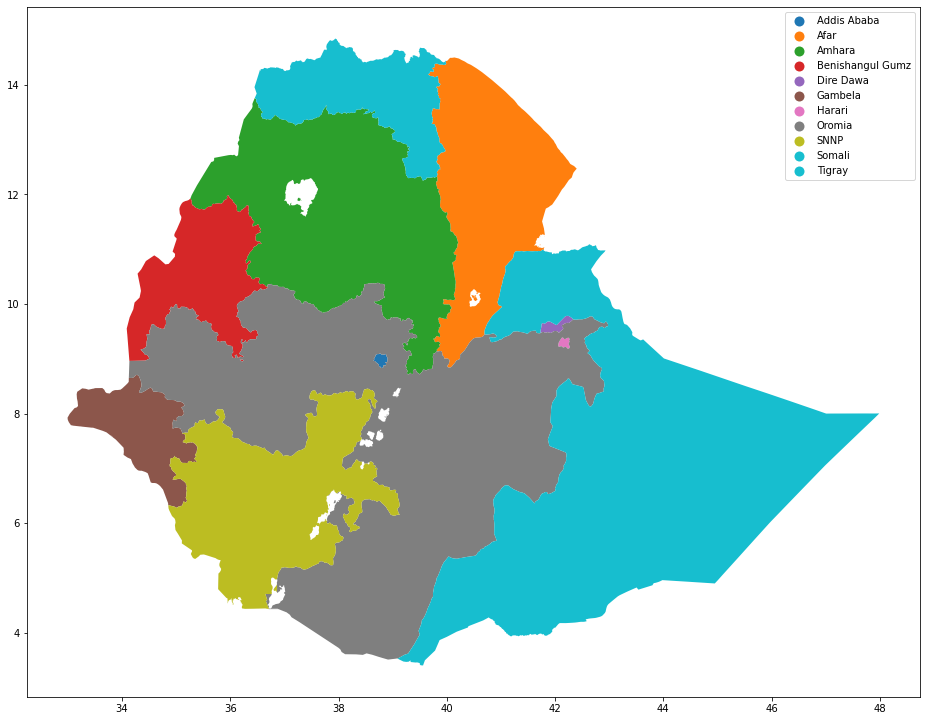

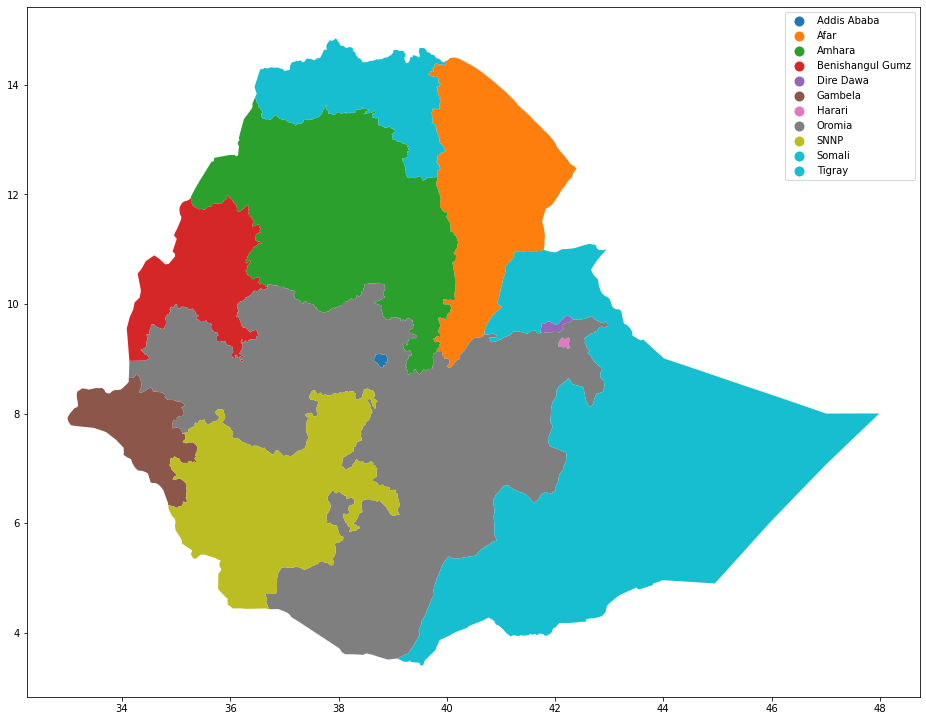

In [33]:
df_livadm_admbound=gpd.read_file("Experiments/livadmbound_test.shp")
fig, axis = plt.subplots(figsize=(16,32))
df_livadm_admbound.plot(column="ADM1_EN",ax=axis,legend=True)
fig, axis = plt.subplots(figsize=(16,32))
# df_adm.boundary.plot(ax=axis)
# df_livadm_admbound.boundary.plot(ax=axis,color="black")
df_adm.plot(column="ADM1_EN",ax=axis,legend=True)